# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 16/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [1]:
# %%capture

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
import datamapplot
import random
from sklearn.metrics.pairwise import cosine_similarity



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine2 import config


dataset = "DREAMACHINE"
condition = "HS"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")


Current working directory: /Users/rb666/Projects/MOSAIC/scripts
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define parameters for current run


In [ ]:

sentences = True
random_seed = SEED # uses the global seed 

# Outlier reduction settings
reduce_outliers = False
outlier_strategy = 'embeddings' 
outlier_threshold = 0.7 #works well with 'embeddings' and 0.7 threshold OR 'probabilities' and 0.15 threshold


### Load and preprocess data


In [3]:

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)

results_dir = os.path.join(project_root, "RESULTS")
results_filename = f"GS_results_{condition}_{'sentences' if sentences else ''}.csv"
results_path = os.path.join(results_dir, results_filename)

print("Loading results from:", results_path)

# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports


Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/HS_reflections_APIcleaned.csv
Loading results from: /Users/rb666/Projects/MOSAIC/RESULTS/GS_results_HS_sentences.csv


0      Intense chaos. And then my mind checked out an...
1                                            Good stuff.
2      A pattern of red and white lights that flashed...
3      I went back to many hard and mostly beautiful ...
4                                                 Hello.
                             ...                        
328    Changing temperature of my body with the light...
329                                 Pleasure & intrigue.
330                            Travelling through space.
331    I thought a lot about Rand's journey into Rhui...
332    The visual here doesn't look anything like wha...
Name: cleaned_reflection, Length: 333, dtype: object

### Pre-processing


In [4]:
if sentences:
    df_reports = split_sentences(df_reports)[0]

print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


Successfully loaded and processed 736 sentences.


In [5]:
min_words = 2 #threshold for minimum words in a sentence

#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")


Hello.
Devtest.
Confusion.
Vast.
Immense.
Tessellations.
Hexagons.
Joy.
Starfields.
devtest
l
it
Beautiful!
Thanks!
Euphoria
Unease
Bizarre.
Everything.
Pareidolia.
Soothed.
Tired.
Joy.
Calm
Warm
h
cakm
Anxiety.
l8
Vertigo.
Peace.
Peace.
Sunlight.
True.

There are 33 sentences with less than 2 words.

After removing short sentences, 703 sentences remain.


In [6]:
#check if there are any duplicate sentences (lists) and remove them
duplicates = [sentence for sentence in df_reports if df_reports.count(sentence) > 1]
df_reports = [sentence for sentence in df_reports if sentence not in duplicates]
print(f"After removing duplicates, {len(df_reports)} sentences remain.\n")

After removing duplicates, 697 sentences remain.



In [7]:
#check if any sentence contains the word "test" (remove if present)
test_sentences = [sentence for sentence in df_reports if re.search(r'test', sentence, re.IGNORECASE)]
if len(test_sentences) > 0:
    print("The following sentences contain the word 'test':")
    for sentence in test_sentences:
        print(sentence)
else:
    print("No sentences contain the word 'test'.\n")

The following sentences contain the word 'test':
The brightest full-vision orange.
Scary, pointy, laughing clown face in test period.
Colors like a test card at first, lightly muted, but then I called pink to mind and saw a wash of deep pink.


### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [8]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: Qwen/Qwen3-Embedding-0.6B


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embeddings and vectorizer ready.


### Setup representation model (before LLM)

In [9]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

### Train BERTopic model 

In [10]:
### Chose either to load best params from grid search or use defaults tailored ones from the config file
# #  Load best params from grid search
# results_GS = pd.read_csv(results_path)
# chosen_params = results_GS.iloc[0]
# print("Best parameters loaded from grid search:")
# print(chosen_params)


# Load default parameters directly from the config
print(f"Loading default parameters for condition: {condition}")
chosen_params = config.get_default_params(condition)

# Print as a Series for nice formatting, similar to the old output
print("Default parameters loaded:")
print(pd.Series(chosen_params))

Loading default parameters for condition: HS
Default parameters loaded:
n_neighbors         15.0
n_components        10.0
min_dist             0.0
min_cluster_size    10.0
min_samples          5.0
top_n_words         15.0
dtype: float64


In [11]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=int(chosen_params['top_n_words']), #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step

2025-09-22 14:58:14,074 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-22 14:58:18,443 - BERTopic - Dimensionality - Completed ✓
2025-09-22 14:58:18,444 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-22 14:58:18,473 - BERTopic - Cluster - Completed ✓
2025-09-22 14:58:18,473 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-09-22 14:58:18,491 - BERTopic - Representation - Completed ✓
2025-09-22 14:58:18,492 - BERTopic - Topic reduction - Reducing number of topics
2025-09-22 14:58:18,495 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-22 14:58:22,739 - BERTopic - Representation - Completed ✓
2025-09-22 14:58:22,740 - BERTopic - Topic reduction - Reduced number of topics from 15 to 12


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [12]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,170,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh..."
1,0,177,0_saw_shapes_patterns_colours,"[saw, shapes, patterns, colours, like, kaleido...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...
2,1,102,1_space_floating_universe_like,"[space, floating, universe, like, body, time, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...","[I saw a map of London, I walked through New Y..."
3,2,48,2_calm_peace_music_relaxation,"[calm, peace, music, relaxation, joy, calming,...","[sense peace, calm relaxing, moments calm, cal...","[calm, peace, relaxation, calming, relaxing, f...","[Peace and contentment., Utter peace and happi..."
4,3,38,3_journey_time_sense_sense time,"[journey, time, sense, sense time, forward, fa...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...","[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_back_old_place,"[memories, back, old, place, strong, like, fee...","[past memories, memories, looking back, rememb...","[memories, place, feeling, womb, memory, beaut...","[Deep memories and emotive reflections., I wen..."
6,5,31,5_asleep_thoughts_thinking_mind,"[asleep, thoughts, thinking, mind, quite, drea...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",[I also felt asleep for a bit and I was thinki...
7,6,29,6_interesting_good_amazing_wonderful,"[interesting, good, amazing, wonderful, still,...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...","[Very interesting!, Thank you; it was very int..."
8,7,26,7_relaxed_safe_also_sense,"[relaxed, safe, also, sense, peaceful, free, r...","[relaxing, calm relaxing, relaxation, sense pe...","[relaxed, safe, peaceful, relaxing, relaxation...",[I was on a journey; I was relaxed and not a b...
9,8,20,8_eyes_light_lights_focused,"[eyes, light, lights, focused, intensity, made...","[flashing lights, lights, lighting, bright lig...","[eyes, light, lights, intensity, made feel, fl...",[I would have liked a slight diffusion on the ...


In [13]:
docs_info = topic_model.get_document_info(df_reports)
docs_info

,Document,Topic,Name,Representation,KeyBERT,MMR,Representative_Docs,Top_n_words,Probability,Representative_document
0,Intense chaos.,3,3_journey_time_sense_sense time,"[journey, time, sense, sense time, forward, fa...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...","[Journey forward., A loss of sense of time, im...",journey - time - sense - sense time - forward ...,0.116409,False
1,And then my mind checked out and my subconscio...,5,5_asleep_thoughts_thinking_mind,"[asleep, thoughts, thinking, mind, quite, drea...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",[I also felt asleep for a bit and I was thinki...,asleep - thoughts - thinking - mind - quite - ...,0.583515,False
2,What I imagine it's like looking back on life ...,10,10_death_life_like_could,"[death, life, like, could, visual thing, start...","[death, life, looking back, imagine, something...","[death, life, visual thing, looking back, imag...",[The cycle of death and rebirth as envisaged i...,death - life - like - could - visual thing - s...,1.000000,False
3,Good stuff.,6,6_interesting_good_amazing_wonderful,"[interesting, good, amazing, wonderful, still,...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...","[Very interesting!, Thank you; it was very int...",interesting - good - amazing - wonderful - sti...,0.350811,False
4,A pattern of red and white lights that flashed...,0,0_saw_shapes_patterns_colours,"[saw, shapes, patterns, colours, like, kaleido...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...,saw - shapes - patterns - colours - like - kal...,0.596079,False
...,...,...,...,...,...,...,...,...,...,...
692,Pleasure & intrigue.,-1,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh...",like - brain - would - body - music - machine ...,0.467323,False
693,Travelling through space.,-1,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh...",like - brain - would - body - music - machine ...,0.656832,False
694,I thought a lot about Rand's journey into Rhui...,1,1_space_floating_universe_like,"[space, floating, universe, like, body, time, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...","[I saw a map of London, I walked through New Y...",space - floating - universe - like - body - ti...,1.000000,False
695,The visual here doesn't look anything like wha...,-1,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh...",like - brain - would - body - music - machine ...,0.683285,False


In [14]:
topic_model.get_representative_docs(1) #get representative documents for topic 1

['I saw a map of London, I walked through New York, I was floating in space like a star or angel and floating through my past memories, forgiving myself for having ever felt sad or numb.',
 'Like I was particles or a star emitting light into space.',
 'I felt like I was on a journey through space riding in a kaleidoscope... it was an out-of-body experience on occasion, and I felt a spinning sensation and like I could see galaxies and star clusters all around my invisible kaleidospacescraft.']

In [15]:
topic_id = 10
all_sentences_topic = [doc for doc, topic in zip(df_reports, topics) if topic == topic_id] #get all sentences assigned to topic 1

print(f"Number of documents assigned to topic {topic_id}: {len(all_sentences_topic)}")
for doc in all_sentences_topic:
    print(doc)

Number of documents assigned to topic 10: 11
What I imagine it's like looking back on life before you die.
Maybe this is what it's like to be dead.
Life after retired.
It kind of felt like dying, reincarnating, and starting life again.
The cycle of death and rebirth as envisaged in eighties D&D.
It felt like the circle of life, a soul leaving and returning.
I hope that's what death feels like.
I wondered if it would be like this when you die.
In brief—I was thinking if death could look like this experience, and so I decided to assume that I go through a near-death experience and check my thoughts about it, so you could build something more than a visual-only thing for me, so I cannot say it was totally useless as I was expecting.
Healing a part of myself I didn't realise had decayed entirely.
Life, death, and rebirth.


In [16]:
topic_id = 1  # Replace with your topic of interest
topic_docs = docs_info[docs_info['Topic'] == topic_id]
topic_docs_sorted = topic_docs.sort_values(by='Probability', ascending=False)#.reset_index(drop=True)


topic_docs_sorted = topic_docs_sorted.rename(columns={
    'Document': 'Sentence',
    'Probability': 'Topic_Probability'
})

result_table = topic_docs_sorted[['Sentence', 'Topic_Probability','Representative_document']]

print(result_table)

result_table.to_csv(f'../RESULTS/dreamachine/topics_content/topic{topic_id}.csv')


                                              Sentence  Topic_Probability  \
333  I left feeling profoundly moved and very tearful.           1.000000   
309                  Towards the end, I went to space.           1.000000   
430                            I was in another world.           1.000000   
410  I felt as though I was experiencing the format...           1.000000   
391                           I was emotionally moved.           1.000000   
..                                                 ...                ...   
456                              This is my 7th visit.           0.208826   
550                            This is my second time.           0.208024   
256                       I must go and eat something.           0.207421   
361  I've visited three times and had a different e...           0.206247   
95                  The second time it was all around.           0.200965   

     Representative_document  
333                    False  
309          

### Initial analysis (before LLM)

In [17]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
print(f"\nInitial Coherence Score (C_v): {initial_coherence}")
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")



Number of valid topics used for coherence calculation (excludes outliers -1): 11

Initial Coherence Score (C_v): 0.4663583047895294
Initial number of topics extracted: 12
Initial number of outlier sentences: 170


### Embedding coherence

In [18]:
# --- For Testing: Define Embedding Coherence Function ---
from sklearn.metrics.pairwise import cosine_similarity


def calculate_embedding_coherence(model, docs, embeddings):
    """
    Calculate the average intra-topic cosine similarity for a BERTopic model.

    Args:
        model (BERTopic): A fitted BERTopic model.
        docs (list of str): The original documents used to fit the model.
        embeddings (np.ndarray): The document embeddings for the training data.

    Returns:
        float: The mean coherence score across all topics.
    """
    # Group documents and their embeddings by topic
    # The original documents ('docs') must be used here to match the length of model.topics_
    documents_df = pd.DataFrame({"Doc": docs, "Topic": model.topics_})
    
    # Ensure embeddings are a numpy array
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array(embeddings)
        
    documents_df['Embedding'] = list(embeddings)

    # Calculate coherence for each topic
    topic_coherence_scores = []
    for topic_id in documents_df['Topic'].unique():
        if topic_id == -1:  # Skip outlier topic
            continue
        
        topic_docs_df = documents_df[documents_df['Topic'] == topic_id]
        
        if len(topic_docs_df) < 2: # Cannot calculate coherence for a single document
            continue

        topic_embeddings = np.vstack(topic_docs_df['Embedding'].values)
        
        # Calculate pairwise similarity and get the mean of the upper triangle
        similarity_matrix = cosine_similarity(topic_embeddings)
        upper_triangle_mean = np.mean(similarity_matrix[np.triu_indices(len(topic_docs_df), k=1)])
        topic_coherence_scores.append(upper_triangle_mean)

    # Return the mean coherence across all topics, or 0.0 if no valid topics found
    return np.mean(topic_coherence_scores) if topic_coherence_scores else 0.0

In [19]:
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Initial Word-Based Coherence Score (C_v): 0.4664
Initial Embedding Coherence Score: 0.5859
Initial number of topics extracted: 12
Initial number of outlier sentences: 170


### Experiment with Vectorizer Settings (without re-training)
use the `.update_topics()` function to quickly test different `CountVectorizer` settings and see how they change the keywords (without re-running the clustering)


In [20]:
# --- First, let's see the keywords from your initial model run for comparison ---
print("--- Initial Keywords (from loaded GS parameters) ---")
# Let's look at the first 4 topics as an example
for topic_id in range(10):
    # The .get_topic() method returns a list of (word, score) tuples
    keywords = [word for word, score in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {keywords}")
print("\n" + "="*80 + "\n")

--- Initial Keywords (from loaded GS parameters) ---
Topic 0: ['saw', 'shapes', 'patterns', 'colours', 'like', 'kaleidoscope', 'blue', 'red', 'geometric', 'sometimes', 'one', 'white', 'black', 'yellow', 'colour']
Topic 1: ['space', 'floating', 'universe', 'like', 'body', 'time', 'moving', 'earth', 'travelling', 'flying', 'end', 'wanted', 'saw', 'sensation', 'feel']
Topic 2: ['calm', 'peace', 'music', 'relaxation', 'joy', 'calming', 'sense', 'relaxing', 'peaceful', 'stimulation', 'deep', 'great', 'love', 'connection', 'feeling']
Topic 3: ['journey', 'time', 'sense', 'sense time', 'forward', 'fast', 'speed', 'images', 'something', 'really', 'understand', 'beats', 'come', 'complete', 'towards something']
Topic 4: ['memories', 'back', 'old', 'place', 'strong', 'like', 'feeling', 'womb', 'self', 'house', 'really', 'stuff', 'find', 'people', 'memory']
Topic 5: ['asleep', 'thoughts', 'thinking', 'mind', 'quite', 'dreaming', 'started', 'brain', 'thought', 'stories', 'sleep', 'awake', 'eyes', '

### Reduce outliers

In [21]:
#print the sentences that have been considered outliers
outlier_sentences = [doc for doc, topic in zip(df_reports, topics) if topic == -1]
print(f"Outlier sentences ({len(outlier_sentences)}):")
for sentence in outlier_sentences:
    print(sentence)

Outlier sentences (170):
I tended to shift between focusing on the sound or the colors.
Sound inside my body.
The vastness was just poetic and beautiful.
A sense of travelling along a galaxy highway towards the end.
The sensory is overwhelming and powerful.
I was scared at first but calmed down after a while.
It feels like a symbolism of acceptance of self, my own fear, and life.
Dream Machine is an unforgettable, magical, and life-affirming experience.
I didn't feel in control and wondered how this would be positive.
Felt similar to being in an MRI machine.
And a sense of really being inside my head.
Dreaming dreamingly.
Difficult to make note of what I was seeing as I've never experienced that before.
There were points that the intense chaos broke into a clear, defined counter-clockwise spiralling tunnel with two small semi-circles at the centre going the opposite way.
The first time it felt more like it was separate from me, in front of my vision.
The Dream Machine has put me in qui

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Store the original topics before the loop
original_topics = topic_model.topics_

# --- Define strategies and thresholds to test ---
strategies = ['probabilities', 'embeddings']
thresholds_to_test = {
    'probabilities': np.arange(0.05, 0.21, 0.05),
    'embeddings': np.arange(0.5, 0.81, 0.05)
}

results = []

# --- Iterate over each strategy and threshold ---
for strategy in strategies:
    for threshold in thresholds_to_test[strategy]:
        print(f"Testing strategy '{strategy}' with threshold {threshold:.2f}...")
        
        # NOTE: The reduce_outliers function checks the internal state of `topic_model` before running.
        # This is why the model must be reset at the end of each iteration.
        new_topics = topic_model.reduce_outliers(
            df_reports, 
            topics, # It is safe to use the original `topics` variable here
            strategy=strategy,
            probabilities=probs,
            embeddings=embeddings,
            threshold=threshold
        )
        
        # Temporarily update the model to calculate coherence with new topics
        topic_model.update_topics(df_reports, topics=new_topics)
        
        # Calculate metrics
        num_outliers = len([t for t in new_topics if t == -1])
        cv_coherence, _ = calculate_coherence(topic_model, df_reports)
        emb_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)

        # Store results
        results.append({
            'Strategy': strategy,
            'Threshold': threshold,
            'Num_Outliers': num_outliers,
            'Cv_Coherence': cv_coherence,
            'Embedding_Coherence': emb_coherence
        })
        
        # THIS IS THE CRITICAL FIX: Reset the model to its original state before the next iteration
        topic_model.update_topics(df_reports, topics=original_topics)

# --- Create and display the results DataFrame ---
results_df = pd.DataFrame(results)
print("\n--- Evaluation Complete ---")
display(results_df)

2025-09-22 14:58:25,300 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Testing strategy 'probabilities' with threshold 0.05...


2025-09-22 14:58:27,805 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:27,830 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'probabilities' with threshold 0.10...


2025-09-22 14:58:30,250 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:30,264 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'probabilities' with threshold 0.15...


2025-09-22 14:58:32,626 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:32,641 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'probabilities' with threshold 0.20...


2025-09-22 14:58:34,985 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:35,012 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.50...


2025-09-22 14:58:37,459 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:37,486 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.55...


2025-09-22 14:58:39,986 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:40,007 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.60...


2025-09-22 14:58:42,485 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:42,507 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.65...


2025-09-22 14:58:44,930 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:44,949 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.70...


2025-09-22 14:58:47,367 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:47,397 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.75...


2025-09-22 14:58:49,832 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-09-22 14:58:49,867 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11
Testing strategy 'embeddings' with threshold 0.80...


2025-09-22 14:58:52,303 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Number of valid topics used for coherence calculation (excludes outliers -1): 11

--- Evaluation Complete ---


,Strategy,Threshold,Num_Outliers,Cv_Coherence,Embedding_Coherence
0,probabilities,0.05,0,0.423110,0.577469
1,probabilities,0.10,38,0.417854,0.578577
2,probabilities,0.15,97,0.411688,0.580795
3,probabilities,0.20,147,0.411688,0.583998
4,embeddings,0.50,5,0.448362,0.565581
5,embeddings,0.55,9,0.447800,0.566414
6,embeddings,0.60,22,0.447553,0.570870
7,embeddings,0.65,45,0.437520,0.576464
8,embeddings,0.70,92,0.424242,0.583394
9,embeddings,0.75,141,0.430589,0.587698


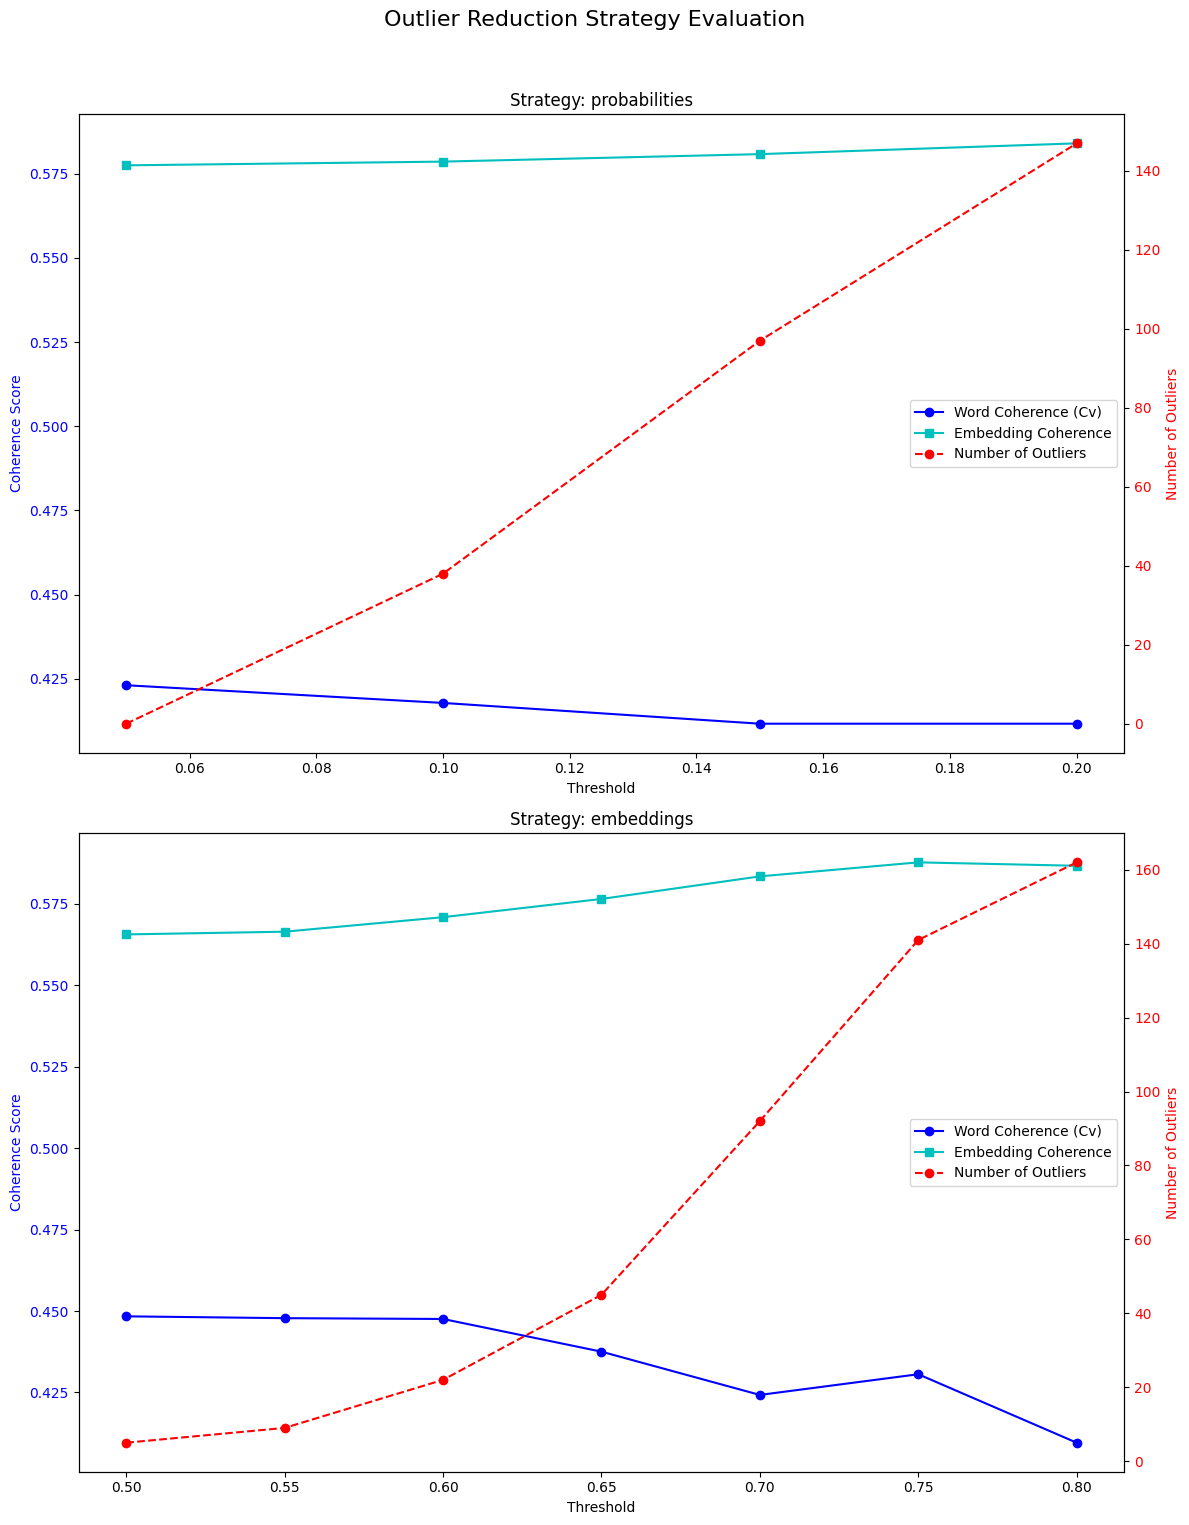

In [23]:
# --- Create plots to visualise the results ---
fig, axes = plt.subplots(len(strategies), 1, figsize=(12, 8 * len(strategies)))
fig.suptitle('Outlier Reduction Strategy Evaluation', fontsize=16)

for i, strategy in enumerate(strategies):
    ax = axes[i]
    strategy_df = results_df[results_df['Strategy'] == strategy]
    
    # Plot coherence scores on the primary y-axis
    ax.plot(strategy_df['Threshold'], strategy_df['Cv_Coherence'], 'o-', color='b', label='Word Coherence (Cv)')
    ax.plot(strategy_df['Threshold'], strategy_df['Embedding_Coherence'], 's-', color='c', label='Embedding Coherence')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Coherence Score', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.set_title(f'Strategy: {strategy}')
    
    # Create a secondary y-axis for the number of outliers
    ax2 = ax.twinx()
    ax2.plot(strategy_df['Threshold'], strategy_df['Num_Outliers'], 'o--', color='r', label='Number of Outliers')
    ax2.set_ylabel('Number of Outliers', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [24]:
# reduce outliers (optional)
if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")

In [25]:
topic_model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [26]:
topic_model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

In [27]:
#print list of keywords for each topic
for topic_id in range(len(topic_model.get_topic_info()) - 1): # Exclude outlier topic
    keywords = [word for word, score in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {keywords}")
print("\n" + "="*80 + "\n")
# Save the model

Topic 0: ['of', 'and', 'saw', 'the', 'shapes', 'like', 'in', 'patterns', 'colours', 'kaleidoscope']
Topic 1: ['was', 'the', 'felt', 'space', 'and', 'through', 'it', 'to', 'of', 'in']
Topic 2: ['calm', 'music', 'peace', 'and', 'relaxation', 'the', 'sense', 'joy', 'calming', 'relaxing']
Topic 3: ['time', 'sense', 'journey', 'of', 'forward', 'fast', 'speed', 'through', 'images', 'and']
Topic 4: ['memories', 'my', 'to', 'back', 'and', 'felt', 'like', 'old', 'place', 'it']
Topic 5: ['my', 'asleep', 'thoughts', 'had', 'was', 'what', 'thinking', 'mind', 'quite', 'and']
Topic 6: ['experience', 'interesting', 'very', 'it', 'good', 'amazing', 'expected', 'thank', 'awesome', 'wonderful']
Topic 7: ['felt', 'relaxed', 'and', 'was', 'safe', 'also', 'of', 'sense', 'very', 'at']
Topic 8: ['the', 'to', 'on', 'my', 'me', 'eyes', 'light', 'of', 'lights', 'made']
Topic 9: ['drugs', 'on', 'lsd', 'dmt', 'closest', 'an', 'psychedelic', 'perhaps', 'being', 'having']
Topic 10: ['death', 'life', 'like', 'it', '

In [28]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    keybert_keywords = row['KeyBERT']
    mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - KeyBERT: {keybert_keywords}")
    print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from KeyBERT and MMR Representations ---

Topic 0:
  - KeyBERT: ['colours shapes', 'kaleidoscopic', 'kaleidoscope', 'yellow like', 'shapes', 'vivid', 'colours', 'shape', 'colors', 'pulsating']
  - MMR:     ['saw', 'shapes', 'patterns', 'colours', 'kaleidoscope', 'blue', 'geometric', 'kaleidoscopic', 'vision', 'eye']

Topic 1:
  - KeyBERT: ['space', 'could see', 'universe', 'sky', 'spaceship', 'past memories', 'journey', 'moving towards', 'flying', 'feeling']
  - MMR:     ['space', 'floating', 'universe', 'body', 'moving', 'flying', 'portal', 'planet', 'journey', 'spinning']

Topic 2:
  - KeyBERT: ['sense peace', 'calm relaxing', 'moments calm', 'calm', 'peace', 'calming', 'peaceful', 'stillness', 'relaxing', 'relaxation']
  - MMR:     ['calm', 'peace', 'relaxation', 'calming', 'relaxing', 'feeling', 'serene', 'sense peace', 'loving', 'louder music']

Topic 3:
  - KeyBERT: ['sense time', 'moving towards', 'towards something', 'motion', 'moving', 'journey', 'away', 'towards'

# Update model with LLAMA 3 for Topic Labelling

In [29]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64  

In [30]:
from bertopic.representation import BaseRepresentation
import re

class MultiKeywordLLM(BaseRepresentation):
    def __init__(self, llm, prompt, pipeline_kwargs):
        super().__init__()
        self.llm = llm
        self.prompt = prompt
        self.pipeline_kwargs = pipeline_kwargs

    def extract_topics(self, topic_model, documents, c_tf_idf, topics):
        """
        This is the main function. For each topic, it will build a custom
        prompt and generate a new label.
        """
        # Get the topic info DataFrame that contains KeyBERT and MMR keywords
        topic_info_df = topic_model.get_topic_info()
        
        # Create the new labels
        new_labels = {}
        for index, row in topic_info_df.iterrows():
            topic_id = row['Topic']
            if topic_id == -1:
                continue

            # Get documents and all keyword sets for the current topic
            docs = "\n".join(topic_model.get_representative_docs(topic_id))
            ctfidf_kws = ", ".join([word for word, score in topic_model.get_topic(topic_id)])
            keybert_kws = ", ".join(row['KeyBERT'])
            mmr_kws = ", ".join(row['MMR'])
            
            # Fill in our detailed prompt
            filled_prompt = self.prompt.replace("[DOCUMENTS]", docs)
            filled_prompt = filled_prompt.replace("[KEYWORDS]", ctfidf_kws)
            filled_prompt = filled_prompt.replace("[KEYBERT_KEYWORDS]", keybert_kws)
            filled_prompt = filled_prompt.replace("[MMR_KEYWORDS]", mmr_kws)

            # Get the new label from the LLM
            response = self.llm(prompt=filled_prompt, **self.pipeline_kwargs)
            label = response['choices'][0]['text'].strip()
            new_labels[topic_id] = re.sub(r'^\d+\.\s*', '', label)
        
        return new_labels
    


# # Your original prompt, but with the new placeholders
# prompt_with_all_keywords = """Q:
# I have a topic with the following sentences associated to it:
# [DOCUMENTS]

# The topic has been described with several keyword sets:
# - Basic Keywords: '[KEYWORDS]'
# - KeyBERT Keywords: '[KEYBERT_KEYWORDS]'
# - MMR Keywords: '[MMR_KEYWORDS]'

# Based on all of the above information, find the most appropriate scientific label for this topic. The label must:

# 1. Use Title Case with proper spacing.
# 2. Reflect directly reported phenomena.
# 3. Be concise yet comprehensive (10 words max).

# Only return the label itself, without any additional text or punctuation.
# A:
# """


prompt_with_all_keywords = """Below are documents and keyword sets that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]
- [MMR_KEYWORDS]

TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.
- Only return the label itself, with no other text.

LABEL:
"""

# Your original pipeline kwargs
pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.3,
    "top_p": 0.7,
    "repeat_penalty": 2
}

# Instantiate our new custom model
custom_llm_model = MultiKeywordLLM(llm, prompt=prompt_with_all_keywords, pipeline_kwargs=pipeline_kwargs)

# Define the representation model using our custom class
representation_model = {"LLM_Custom": custom_llm_model}

# UPDATE THE FITTED MODEL - this now works as you originally wanted
print("Updating topic representations with custom Llama 3 prompter...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")

# You can now get your new, improved labels
topic_model.get_topic_info()

Updating topic representations with custom Llama 3 prompter...
Update complete.


,Topic,Count,Name,Representation,KeyBERT,MMR,LLM_Custom,Representative_Docs
0,-1,170,-1_the_and_to_it,"[the, and, to, it, of, was, in, my, like, felt]","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...",NaN,"[It felt like my brain was being massaged., Wh..."
1,0,177,0_of_and_saw_the,"[of, and, saw, the, shapes, like, in, patterns...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",Kaleidoscopic Patterns of Colour and Shape\n``...,[I saw many kinds of patterns from sparks to g...
2,1,102,1_was_the_felt_space,"[was, the, felt, space, and, through, it, to, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...",Out-of-Body Experience in Space and Time\n\n``...,"[I saw a map of London, I walked through New Y..."
3,2,48,2_calm_music_peace_and,"[calm, music, peace, and, relaxation, the, sen...","[sense peace, calm relaxing, moments calm, cal...","[calm, peace, relaxation, calming, relaxing, f...",Calm and Peaceful State of Mind\n```\n\nThe ta...,"[Peace and contentment., Utter peace and happi..."
4,3,38,3_time_sense_journey_of,"[time, sense, journey, of, forward, fast, spee...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...",Perceptual Disruption of Temporal Experience\n...,"[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_my_to_back,"[memories, my, to, back, and, felt, like, old,...","[past memories, memories, looking back, rememb...","[memories, place, feeling, womb, memory, beaut...","""Revisiting Childhood Memories and Emotions""\n...","[Deep memories and emotive reflections., I wen..."
6,5,31,5_my_asleep_thoughts_had,"[my, asleep, thoughts, had, was, what, thinkin...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",Dream-Like State of Semiconsciousness\n```\n\n...,[I also felt asleep for a bit and I was thinki...
7,6,29,6_experience_interesting_very_it,"[experience, interesting, very, it, good, amaz...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...",Interesting Experience with Positive Emotions\...,"[Very interesting!, Thank you; it was very int..."
8,7,26,7_felt_relaxed_and_was,"[felt, relaxed, and, was, safe, also, of, sens...","[relaxing, calm relaxing, relaxation, sense pe...","[relaxed, safe, peaceful, relaxing, relaxation...",Relaxed and Safe Experience\n```\n\nHere is th...,[I was on a journey; I was relaxed and not a b...
9,8,20,8_the_to_on_my,"[the, to, on, my, me, eyes, light, of, lights,...","[flashing lights, lights, lighting, bright lig...","[eyes, light, lights, intensity, made feel, fl...",Strobe Light-Induced Visual Discomfort Phenome...,[I would have liked a slight diffusion on the ...


In [31]:
from bertopic.representation import BaseRepresentation
import re

class MultiKeywordLLM(BaseRepresentation):
    def __init__(self, llm, prompt,pipeline_kwargs,nr_docs=10):
        super().__init__()
        self.llm = llm
        self.prompt = prompt
        self.pipeline_kwargs = pipeline_kwargs
        self.nr_docs = nr_docs 

    def extract_topics(self, topic_model, documents, c_tf_idf, topics):
        """
        This is the main function. For each topic, it will build a custom
        prompt and generate a new label.
        """
        # Get the topic info DataFrame that contains KeyBERT and MMR keywords
        topic_info_df = topic_model.get_topic_info()
        
        # Create the new labels
        new_labels = {}
        for index, row in topic_info_df.iterrows():
            topic_id = row['Topic']
            if topic_id == -1:
                continue

            # Get documents and all keyword sets for the current topic
            docs = "\n".join(topic_model.get_representative_docs(topic_id))
            ctfidf_kws = ", ".join([word for word, score in topic_model.get_topic(topic_id)])
            keybert_kws = ", ".join(row['KeyBERT'])
            mmr_kws = ", ".join(row['MMR'])
            
            # Fill in our detailed prompt
            filled_prompt = self.prompt.replace("[DOCUMENTS]", docs)
            filled_prompt = filled_prompt.replace("[KEYWORDS]", ctfidf_kws)
            filled_prompt = filled_prompt.replace("[KEYBERT_KEYWORDS]", keybert_kws)
            filled_prompt = filled_prompt.replace("[MMR_KEYWORDS]", mmr_kws)

            # Get the new label from the LLM
            response = self.llm(prompt=filled_prompt, **self.pipeline_kwargs)
            label = response['choices'][0]['text'].strip()
            new_labels[topic_id] = re.sub(r'^\d+\.\s*', '', label)
        
        return new_labels
    


# # Your original prompt, but with the new placeholders
# prompt_with_all_keywords = """Q:
# I have a topic with the following sentences associated to it:
# [DOCUMENTS]

# The topic has been described with several keyword sets:
# - Basic Keywords: '[KEYWORDS]'
# - KeyBERT Keywords: '[KEYBERT_KEYWORDS]'
# - MMR Keywords: '[MMR_KEYWORDS]'

# Based on all of the above information, find the most appropriate scientific label for this topic. The label must:

# 1. Use Title Case with proper spacing.
# 2. Reflect directly reported phenomena.
# 3. Be concise yet comprehensive (10 words max).

# Only return the label itself, without any additional text or punctuation.
# A:
# """


prompt_with_all_keywords = """Below are documents and keyword sets that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]
- [MMR_KEYWORDS]

TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.
- Only return the label itself, with no other text.

LABEL:
"""

# Your original pipeline kwargs
pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.3,
    "top_p": 0.7,
    "repeat_penalty": 2
}

# Instantiate our new custom model
custom_llm_model = MultiKeywordLLM(llm, prompt=prompt_with_all_keywords,pipeline_kwargs=pipeline_kwargs,nr_docs=10)

# Define the representation model using our custom class
representation_model = {"LLM_Custom": custom_llm_model}

# UPDATE THE FITTED MODEL - this now works as you originally wanted
print("Updating topic representations with custom Llama 3 prompter...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")

# You can now get your new, improved labels
topic_model.get_topic_info()

Updating topic representations with custom Llama 3 prompter...
Update complete.


,Topic,Count,Name,Representation,KeyBERT,MMR,LLM_Custom,Representative_Docs
0,-1,170,-1_the_and_to_it,"[the, and, to, it, of, was, in, my, like, felt]","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...",NaN,"[It felt like my brain was being massaged., Wh..."
1,0,177,0_of_and_saw_the,"[of, and, saw, the, shapes, like, in, patterns...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",Kaleidoscopic Visual Patterns and Shapes Emerg...,[I saw many kinds of patterns from sparks to g...
2,1,102,1_was_the_felt_space,"[was, the, felt, space, and, through, it, to, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...",Out-of-Body Experience in Space-Time Continuum...,"[I saw a map of London, I walked through New Y..."
3,2,48,2_calm_music_peace_and,"[calm, music, peace, and, relaxation, the, sen...","[sense peace, calm relaxing, moments calm, cal...","[calm, peace, relaxation, calming, relaxing, f...",Calm and Peaceful State of Mind\n```\n\nThe ta...,"[Peace and contentment., Utter peace and happi..."
4,3,38,3_time_sense_journey_of,"[time, sense, journey, of, forward, fast, spee...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...",Perceptual Disruption of Temporal Experience\n...,"[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_my_to_back,"[memories, my, to, back, and, felt, like, old,...","[past memories, memories, looking back, rememb...","[memories, place, feeling, womb, memory, beaut...","""Vivid Memories of Childhood Experiences""\n```...","[Deep memories and emotive reflections., I wen..."
6,5,31,5_my_asleep_thoughts_had,"[my, asleep, thoughts, had, was, what, thinkin...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",Dreamlike State of Semiconsciousness\n```\n\nT...,[I also felt asleep for a bit and I was thinki...
7,6,29,6_experience_interesting_very_it,"[experience, interesting, very, it, good, amaz...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...",Interesting Experience Report\n```\n\nThe task...,"[Very interesting!, Thank you; it was very int..."
8,7,26,7_felt_relaxed_and_was,"[felt, relaxed, and, was, safe, also, of, sens...","[relaxing, calm relaxing, relaxation, sense pe...","[relaxed, safe, peaceful, relaxing, relaxation...",Relaxed and Safe Experience with Sense of Peac...,[I was on a journey; I was relaxed and not a b...
9,8,20,8_the_to_on_my,"[the, to, on, my, me, eyes, light, of, lights,...","[flashing lights, lights, lighting, bright lig...","[eyes, light, lights, intensity, made feel, fl...",Strobe Lighting and Its Effects on Visual Perc...,[I would have liked a slight diffusion on the ...


In [32]:
#print LLM custom keywords for each topic
print("--- Keywords from Custom Llama 3 Representation ---")
# Iterate over each row in the DataFrame
for index, row in topic_model.get_topic_info().iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    llm_custom_keywords = row['LLM_Custom']
    
    # Print the keywords for the current topic
    print(f"Topic {topic_id}: {llm_custom_keywords}")
print("\n" + "="*80 + "\n")

--- Keywords from Custom Llama 3 Representation ---
Topic 0: Kaleidoscopic Visual Patterns and Shapes Emerge
```

Here
Topic 1: Out-of-Body Experience in Space-Time Continuum
"""

# Define the
Topic 2: Calm and Peaceful State of Mind
```

The task is to
Topic 3: Perceptual Disruption of Temporal Experience
```
The output is
Topic 4: "Vivid Memories of Childhood Experiences"
```

The task is to
Topic 5: Dreamlike State of Semiconsciousness
```

This is a simple
Topic 6: Interesting Experience Report
```

The task is to generate a single, scientific
Topic 7: Relaxed and Safe Experience with Sense of Peace
```

The task is
Topic 8: Strobe Lighting and Its Effects on Visual Perception
```

The task is
Topic 9: Psychedelic Experience Lacking Emotional Connection
```

The task is to
Topic 10: Near-Death Experience and Rebirth Imagery
```

The task is




In [33]:
#print LLM custom keywords for each topic
print("--- Keywords from Custom Llama 3 Representation ---")
# Iterate over each row in the DataFrame
for index, row in topic_model.get_topic_info().iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    llm_custom_keywords = row['LLM']
    
    # Print the keywords for the current topic
    print(f"Topic {topic_id}: {llm_custom_keywords}")
print("\n" + "="*80 + "\n")

--- Keywords from Custom Llama 3 Representation ---


KeyError: 'LLM'

In [ ]:


prompt = """Q:
I have a topic with the following sentences associated to it:
[DOCUMENTS]

The topic has been described with several keyword sets:
- Basic Keywords: '[KEYWORDS]'
- KeyBERT Keywords: '[KEYBERT_KEYWORDS]'
- MMR Keywords: '[MMR_KEYWORDS]'

Based on all of the above information, find the most appropriate scientific label for this topic. The label must:

1. Uses Title Case with proper spacing
2. Reflects directly reported phenomena
3. Be concise yet comprehensive (10 words max)

Only return the label itself, without any additional text or punctuation.
A:
"""

pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.3,    # conservative to minimise randomness and hallucinations
    "top_p": 0.7, # Range: 0 to 1. Focus on most probable tokens from the input
    "repeat_penalty": 2 # >1.0: penalise repeated words, useful for avoiding redundant terms in labels
}

representation_model = {"LLM": LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)}


# UPDATE THE FITTED MODEL WITH THE NEW REPRESENTATION MODEL (not re-training)
print("Updating topic representations with Llama 3...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


Updating topic representations with Llama 3...


100%|██████████| 12/12 [00:17<00:00,  1.47s/it]

Update complete.


### Process and apply topic labels generated by Llama3


In [ ]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Outlier" for topic in topics] #create mapping for all sentences
len(all_labels) #should be the same as the sentences

#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Visual Perception Experience',
 1: 'Out-of-Body Experience with Cosmic and Cellular Visualization',
 2: 'Musical Meditation Experience',
 3: 'Time Perception Anomalies and Disruptions',
 4: 'Nostalgic Flashbacks and Emotional Resonance',
 5: 'Mind-Wandering During Meditation',
 6: 'Subjective Experience of Synesthesia',
 7: 'Spiritual or Meditative Experience',
 8: 'Subjective Experience of Strobe Light Intensity and Visual Perception',
 9: 'Psychedelic Experience and Emotional Processing',
 10: 'Near-Death Experience Phenomenology'}

### Visualisation

In [ ]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

### create and save final topic summary

In [ ]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")
